In [4]:
import pickle
import pandas as pd

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
import streamlit as st # streamlit run Housing.py -- Run that
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [5]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', 
                 sep='\t',
                 usecols=columns)


In [6]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

df.isnull().sum()

df = df.dropna(axis=0)

In [7]:
forest = RandomForestRegressor(n_estimators=50, min_samples_split=4)
sc = StandardScaler()


In [8]:
pipeline = Pipeline([
    ("scaler",sc), 
    ("rfr", forest)

])

X = df[['Gr Liv Area','Overall Qual', 'Overall Cond', 'Gr Liv Area', 
           'Central Air', 'Total Bsmt SF']].values # Defining all my features variables
Y = df['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

pipeline.fit(X_train,y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('rfr',
                 RandomForestRegressor(min_samples_split=4, n_estimators=50))])

In [9]:
y_pred = pipeline.predict(X_test)
R2 = metrics.r2_score(y_test, y_pred)
R2

0.8648773089809046

In [10]:
#param_grid = {
#    'rfr__n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
#    'rfr__max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider at every split
#    'rfr__max_depth': [None, 10, 20, 30, 40, 50],    # Maximum number of levels in each decision tree
#    'rfr__min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
#    'rfr__min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at each leaf node
#    'rfr__bootstrap': [True, False]                  # Method of selecting samples for training each tree
#}

# Corrected parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator= forest, param_distributions=param_grid,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs= 3)


random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
151 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\julio\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(min_samples_split=4,
                                                   n_estimators=50),
                   n_iter=100, n_jobs=3,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [11]:

parameters = random_search.best_params_
parameters

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [12]:
best_estimator = random_search.best_estimator_
best_estimator.fit(X_train, y_train)
predictions = best_estimator.predict(X_test)

In [13]:
r2 = metrics.r2_score(y_test, predictions)
r2

0.8410384428281334

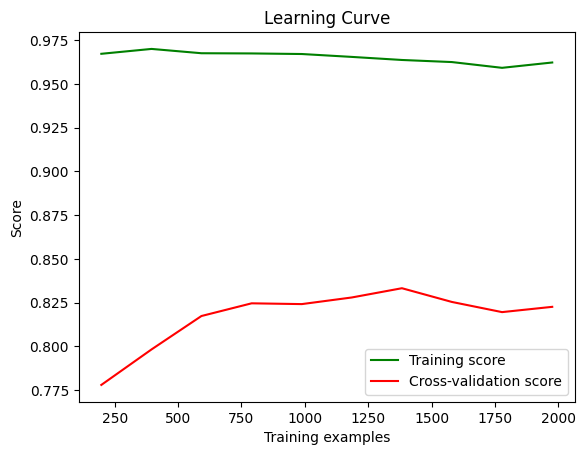

In [17]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, validation_curve
import matplotlib.pyplot as plt

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=10, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Training score', color = "green")
plt.plot(train_sizes, test_mean, label='Cross-validation score', color = "red")
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend()
plt.show()

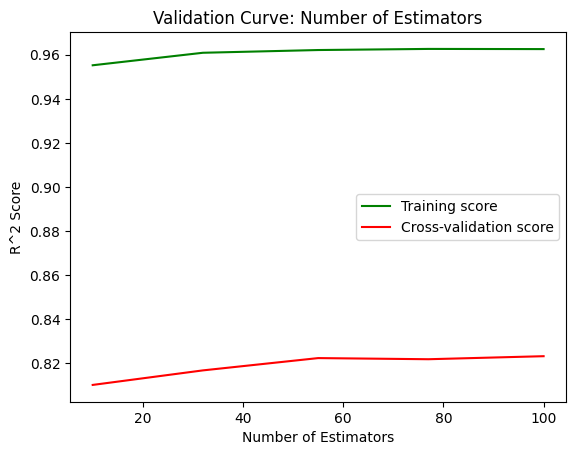

In [16]:
# Validation Curve
param_range = np.linspace(10, 100, 5).astype(int)
train_scores, test_scores = validation_curve(
    pipeline, X_train, y_train, param_name='rfr__n_estimators', param_range=param_range, cv=10, scoring="r2"
)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(param_range, train_mean, label='Training score', color = "green")
plt.plot(param_range, test_mean, label='Cross-validation score', color = "red")
plt.title("Validation Curve: Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("R^2 Score")
plt.legend()
plt.show()
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
cv_std = np.std(cv_scores)
print(f"R2 Score: {r2:.4f} ± {cv_std:.4f}")

In [18]:
from sklearn.cluster import KMeans

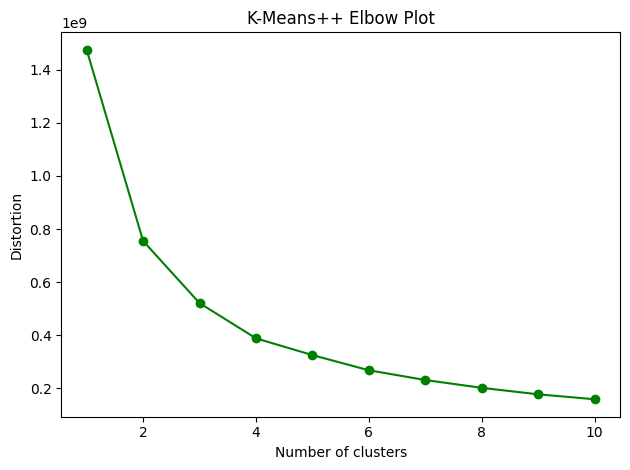

In [21]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300,
                random_state=0)
    km.fit(X_train)
    distortions.append(km.inertia_)




    
plt.plot(range(1, 11), distortions, marker='o', color = "green")
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title("K-Means++ Elbow Plot")
plt.tight_layout()
plt.show() 